##Prepare dataset and code

In [1]:
#mount google drive 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#set myDrive as current path
%cd '/content/drive/MyDrive'

/content/drive/MyDrive


In [3]:
#get data and other code from github
!git clone https://github.com/ShengfangM/finalProject.git 

Cloning into 'finalProject'...
remote: Enumerating objects: 37, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 37 (delta 11), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (37/37), done.


In [4]:
#copy all data to google drive to run the code
!unzip '/content/drive/MyDrive/finalProject/RGB.zip' -d '/content/drive/MyDrive/finalProject/'

Archive:  /content/drive/MyDrive/finalProject/RGB.zip
   creating: /content/drive/MyDrive/finalProject/RGB/
   creating: /content/drive/MyDrive/finalProject/RGB/train/
  inflating: /content/drive/MyDrive/finalProject/RGB/train/annotations.json  
   creating: /content/drive/MyDrive/finalProject/RGB/train/Images/
  inflating: /content/drive/MyDrive/finalProject/RGB/train/Images/071219_Composit_Peanut_blue_green_red_8bit_dataclip_100.png  
  inflating: /content/drive/MyDrive/finalProject/RGB/train/Images/071219_Composit_Peanut_blue_green_red_8bit_dataclip_1000.png  
  inflating: /content/drive/MyDrive/finalProject/RGB/train/Images/071219_Composit_Peanut_blue_green_red_8bit_dataclip_1001.png  
  inflating: /content/drive/MyDrive/finalProject/RGB/train/Images/071219_Composit_Peanut_blue_green_red_8bit_dataclip_1002.png  
  inflating: /content/drive/MyDrive/finalProject/RGB/train/Images/071219_Composit_Peanut_blue_green_red_8bit_dataclip_1003.png  
  inflating: /content/drive/MyDrive/finalPr

## Install more packages


In [2]:
#install all required package to run the code
!pip install gdal
!pip install cython
# Install pycocotools, the version by default in Colab
# has a bug fixed in https://github.com/cocodataset/cocoapi/pull/354
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-8gt3n00t
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-8gt3n00t
  Created wheel for pycocotools: filename=pycocotools-2.0-cp38-cp38-linux_x86_64.whl size=304469 sha256=c7577e508703db9a538142f002a1e8559788d23d4ef44bed5e662927cc2bf1e7
  Stored in directory: /tmp/pip-ephem-wheel-cache-k000obmw/wheels/56/da/49/cb71a7c450b59588934077f431100c05fbde50646ee84a8d40
Successfully built pycocotools
  Attempting uninstall: pycocotools
    Found existing installation: pycocotools 2.0.6
    Uninstalling pycocotools-2.0.6:
      Successfully uninstalled pycocotools-2.0.6


In [3]:
#change the current path 
# there are many cited code files here
%cd /content/drive/MyDrive/finalProject

/content/drive/MyDrive/finalProject


##import needed library

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from osgeo import gdal, gdalnumeric
from gdalRW import getMeta, getAllData

import torch
import torchvision
from torchvision.models.detection.rpn import AnchorGenerator


In [5]:
# pretrained weights
model_urls = {
    'ssd300_vgg16_coco': 'https://download.pytorch.org/models/ssd300_vgg16_coco-b556d3b4.pth',
    'ssd320_lite_coco': "https://download.pytorch.org/models/ssdlite320_mobilenet_v3_large_coco-a79551df.pth",
    'ssd300_res50_coco': 'https://api.ngc.nvidia.com/v2/models/nvidia/ssd_pyt_ckpt_amp/versions/20.06.0/files/nvidia_ssdpyt_amp_200703.pt',
    'fasterrcnn_resnet50_fpn_coco':
        'https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth',
    'fasterrcnn_mobilenet_v3_large_320_fpn_coco':
        'https://download.pytorch.org/models/fasterrcnn_mobilenet_v3_large_320_fpn-907ea3f9.pth',
    'fasterrcnn_mobilenet_v3_large_fpn_coco':
        'https://download.pytorch.org/models/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth'
}

# Start Training
the following code are referred from https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html

# SSD Model

###Prepare dataset for training

Define batchsize here


In [6]:
from peanutDataset import peanutDroneDataset,get_transform
import utils

# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)
torch.cuda.empty_cache() 

root = '/content/drive/MyDrive/finalProject/RGB/train'
valid_root = "/content/drive/MyDrive/finalProject/RGB/validate"

# # our dataset has two classes only - background and person
num_classes = 2
# # use our dataset and defined transformations
dataset = peanutDroneDataset(root, get_transform(train=True),target_transforms = None)
dataset_test = peanutDroneDataset(valid_root, get_transform(train=False),target_transforms = None)

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=6, shuffle=True, num_workers=0,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=0,
    collate_fn=utils.collate_fn)


cuda


## Get the model

In [38]:
# library for this function
from resnetssd import ResNet, res_extractor
from torchvision.models.detection.ssdlite import SSDLite320_MobileNet_V3_Large_Weights

# function tu build ssd model with backbone 
#
def custom_ssd_model(backbone, num_classes):

  if(backbone == 'resnet50'):
  # Use custom backbones more appropriate for SSD
    backbone=ResNet('resnet50')
    backbone=res_extractor(backbone)
    #   backbone = vgg16(weights=weights_backbone, progress=progress)
    # backbone = _res_extractor(backbone, False, trainable_backbone_layers)

    anchor_generator = torchvision.models.detection.anchor_utils.DefaultBoxGenerator(
            [[2], [2, 3], [2, 3], [2, 3], [2], [2]],
            scales=[0.07, 0.15, 0.33, 0.51, 0.69, 0.87, 1.05],
            steps=[8, 16, 32, 64, 100, 300],
        )

    model = torchvision.models.detection.ssd.SSD(backbone,anchor_generator, (300,300), num_classes=num_classes)
    mstate_dict = model.state_dict()

    # get pretrained weights from NVIDIA_SSD
    ssd_model2 = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_ssd')
    cstate_dict= ssd_model2.state_dict()
    # Step 3.
    # Step 3.
    i = 0
    ck = []
    for cki in cstate_dict.keys():
      ck.append(cki)

    for k in mstate_dict.keys():
      cki = ck[i]
      i += 1

      if mstate_dict[k].shape == cstate_dict[cki].shape:

        mstate_dict[k] = cstate_dict[cki]
        
    model.load_state_dict(mstate_dict, strict=False)

  elif (backbone == 'mobilenet_v3'):
        
      #     num_classes = 2
      # Step 1.
      model = torchvision.models.detection.ssdlite320_mobilenet_v3_large(weights=None, num_classes=num_classes)
      # Step 2, load the model state_dict and the default model's state_dict
      progress=True
      mstate_dict = model.state_dict()
      #     cstate_dict = torch.load(args.weights)
      # cstate_dict = torchvision._internally_replaced_utils.load_state_dict_from_url(model_urls['ssd320_lite_coco'],
      #                                           progress=progress)
      
      model2 = torchvision.models.detection.ssdlite320_mobilenet_v3_large(weights=SSDLite320_MobileNet_V3_Large_Weights.DEFAULT)
      cstate_dict = model2.state_dict()
      # # Step 3.
      for k in mstate_dict.keys():

        # print('key {} orishape: {}, training shape: {}'.format(k, cstate_dict[k].shape, mstate_dict[k].shape))

        if mstate_dict[k].shape != cstate_dict[k].shape:
            print('key {} will be removed'.format(k))
            # # cstate_dict.pop(k)
            # tt = cstate_dict[k].shape[0]              
            # mstate_dict[k][:tt] = cstate_dict[k]
            # mstate_dict[k][tt:] = cstate_dict[k]
        else:
          mstate_dict[k]= cstate_dict[k]
      # Step 4.
      model.load_state_dict(mstate_dict, strict=False)
    
  elif(backbone == 'vgg16'):

      model = torchvision.models.detection.ssd300_vgg16(pretrained=False, num_classes=num_classes)
       # Step 2, load the model state_dict and the default model's state_dict
      progress=True
      mstate_dict = model.state_dict()
      #     cstate_dict = torch.load(args.weights)
      cstate_dict = torchvision._internally_replaced_utils.load_state_dict_from_url(model_urls['ssd300_vgg16_coco'],
                                                progress=progress)
            # # Step 3.
      for k in mstate_dict.keys():

        if mstate_dict[k].shape != cstate_dict[k].shape:
            print('key {} will be removed'.format(k))
            cstate_dict.pop(k)
            # tt = cstate_dict[k].shape[0]              
            # mstate_dict[k][:tt] = cstate_dict[k]
            # mstate_dict[k][tt:] = cstate_dict[k]

      # Step 4.
      model.load_state_dict(cstate_dict, strict=False)

  return model

## Train the model

> First get ssd model.
There are three backbone models available here: resnet50, vgg16, and mobilenet_v3

In [39]:
# backbone = 'resnet50' 
# backbone = 'vgg16' 
backbone = 'mobilenet_v3'
#load the ssd model
ssd_model = custom_ssd_model(backbone, num_classes)

# move model to the right device
ssd_model.to(device)


key backbone.features.1.0.3.0.weight will be removed
key backbone.features.1.0.3.1.weight will be removed
key backbone.features.1.0.3.1.bias will be removed
key backbone.features.1.0.3.1.running_mean will be removed
key backbone.features.1.0.3.1.running_var will be removed
key backbone.features.1.1.block.0.0.weight will be removed
key backbone.features.1.1.block.0.1.weight will be removed
key backbone.features.1.1.block.0.1.bias will be removed
key backbone.features.1.1.block.0.1.running_mean will be removed
key backbone.features.1.1.block.0.1.running_var will be removed
key backbone.features.1.1.block.1.0.weight will be removed
key backbone.features.1.1.block.1.1.weight will be removed
key backbone.features.1.1.block.1.1.bias will be removed
key backbone.features.1.1.block.1.1.running_mean will be removed
key backbone.features.1.1.block.1.1.running_var will be removed
key backbone.features.1.1.block.2.fc1.weight will be removed
key backbone.features.1.1.block.2.fc1.bias will be remove

SSD(
  (backbone): SSDLiteFeatureExtractorMobileNet(
    (features): Sequential(
      (0): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (2): Hardswish()
        )
        (1): InvertedResidual(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
              (1): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
              (2): ReLU(inplace=True)
            )
            (1): Conv2dNormActivation(
              (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (1): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
            )
          )
        )
        (2): Invert

In [15]:
# construct an optimizer
params = [p for p in ssd_model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.00075,
                            momentum=0.9, weight_decay=0.000075)
# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [16]:
from engine import train_one_epoch, evaluate

# let's train it for 10 epochs
num_epochs = 6

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(ssd_model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    
    if (epoch)%5 ==0:
        torch.save(ssd_model, 'ssd_model_' +backbone+'_rgb_{}.pth'.format(epoch))
           
    # evaluate on the test dataset
    evaluate(ssd_model, data_loader_test, device=device)

print("Training process ended!")

Epoch: [0]  [ 0/84]  eta: 0:00:10  lr: 0.000010  loss: 8.1026 (8.1026)  bbox_regression: 2.8221 (2.8221)  classification: 5.2805 (5.2805)  time: 0.1227  data: 0.0368  max mem: 651
Epoch: [0]  [10/84]  eta: 0:00:08  lr: 0.000100  loss: 7.7350 (8.0566)  bbox_regression: 2.6689 (2.6478)  classification: 5.3373 (5.4088)  time: 0.1117  data: 0.0357  max mem: 679
Epoch: [0]  [20/84]  eta: 0:00:07  lr: 0.000190  loss: 7.6136 (7.7791)  bbox_regression: 2.3923 (2.6072)  classification: 5.2056 (5.1719)  time: 0.1118  data: 0.0344  max mem: 679
Epoch: [0]  [30/84]  eta: 0:00:05  lr: 0.000281  loss: 6.7885 (7.1967)  bbox_regression: 2.2191 (2.3607)  classification: 4.4772 (4.8361)  time: 0.1067  data: 0.0335  max mem: 679
Epoch: [0]  [40/84]  eta: 0:00:04  lr: 0.000371  loss: 5.5476 (6.7037)  bbox_regression: 1.6738 (2.1664)  classification: 3.8030 (4.5373)  time: 0.1040  data: 0.0352  max mem: 679
Epoch: [0]  [50/84]  eta: 0:00:03  lr: 0.000461  loss: 4.8850 (6.3066)  bbox_regression: 1.4207 (2.0

#Faster RCNN model

### Prepare dataset

In [17]:
from peanutDataset import peanutDroneDataset,get_transform
import utils

# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)
torch.cuda.empty_cache() 

root = '/content/drive/MyDrive/finalProject/RGB/train'
valid_root = "/content/drive/MyDrive/finalProject/RGB/validate"

# # our dataset has two classes only - background and person
num_classes = 2
# # use our dataset and defined transformations
dataset = peanutDroneDataset(root, get_transform(train=True),target_transforms = None)
dataset_test = peanutDroneDataset(valid_root, get_transform(train=False),target_transforms = None)

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=6, shuffle=True, num_workers=0,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=0,
    collate_fn=utils.collate_fn)


cuda


##Get Faster RCNN model

In [18]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

#get pretrained faster rcnn
def get_FasterRCNN(backbone, num_classes, pret=True):
  # load a model pre-trained pre-trained on COCO
  if backbone == 'resnet50':
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=pret)
  elif  backbone == 'mobilenet_v3':
  #model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_320_fpn(pretrained=pret)
    model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=pret)
  else:
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=pret)    

  # replace the classifier with a new one, that has
  # num_classes which is user-defined
  num_classes = 2  # 1 class (person) + background
  # get number of input features for the classifier
  in_features = model.roi_heads.box_predictor.cls_score.in_features
  # replace the pre-trained head with a new one
  model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 

  return model

##Train Faster RCNN model

In [19]:

# backbone = 'resnet50' 
# backbone = 'vgg16' 
backbone = 'mobilenet_v3'
# get the faster RCNN model based on the backbone
FRCNNmodel = get_FasterRCNN(backbone, num_classes)

# move model to the right device
FRCNNmodel.to(device)


/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=FasterRCNN_MobileNet_V3_Large_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_MobileNet_V3_Large_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth


  0%|          | 0.00/74.2M [00:00<?, ?B/s]

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): FrozenBatchNorm2d(16, eps=1e-05)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
            (2): ReLU(inplace=True)
          )
          (1): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
          )
        )
      )
      (2): InvertedResidual(
        (block):

In [20]:

# construct an optimizer
params = [p for p in FRCNNmodel.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.00075,
                            momentum=0.9, weight_decay=0.000075)
# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [21]:
from engine import train_one_epoch, evaluate
# let's train it for 10 epochs
num_epochs = 6

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(FRCNNmodel, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    
    if (epoch)%5 ==0:
        torch.save(FRCNNmodel, 'FasterRCNN_'+backbone+'_rgb_{}.pth'.format(epoch))
           
    # evaluate on the test dataset
    evaluate(FRCNNmodel, data_loader_test, device=device)

print("That's it!")

Epoch: [0]  [ 0/84]  eta: 0:00:38  lr: 0.000010  loss: 1.5730 (1.5730)  loss_classifier: 0.6080 (0.6080)  loss_box_reg: 0.4749 (0.4749)  loss_objectness: 0.4575 (0.4575)  loss_rpn_box_reg: 0.0326 (0.0326)  time: 0.4546  data: 0.0695  max mem: 1224
Epoch: [0]  [10/84]  eta: 0:00:18  lr: 0.000100  loss: 1.4423 (1.4367)  loss_classifier: 0.5861 (0.5803)  loss_box_reg: 0.5905 (0.5755)  loss_objectness: 0.2239 (0.2607)  loss_rpn_box_reg: 0.0194 (0.0203)  time: 0.2567  data: 0.0367  max mem: 1520
Epoch: [0]  [20/84]  eta: 0:00:17  lr: 0.000190  loss: 1.3152 (1.3419)  loss_classifier: 0.5195 (0.5287)  loss_box_reg: 0.6492 (0.6178)  loss_objectness: 0.1544 (0.1781)  loss_rpn_box_reg: 0.0157 (0.0173)  time: 0.2610  data: 0.0358  max mem: 1614
Epoch: [0]  [30/84]  eta: 0:00:15  lr: 0.000281  loss: 1.2550 (1.3045)  loss_classifier: 0.4600 (0.5002)  loss_box_reg: 0.7026 (0.6548)  loss_objectness: 0.0514 (0.1333)  loss_rpn_box_reg: 0.0133 (0.0161)  time: 0.2902  data: 0.0389  max mem: 1614
Epoch: [

# Evaluate models

In [96]:
# get the trained model 
checkpoints = ["FasterRCNN_res50_rgb_5.pth", "FasterRCNN_mobilev3_rgb_5.pth","SSD_res50_rgb_5.pth","SSD_mobilev3_rgb_5.pth"]
# choose the model to load
model = torch.load(checkpoints[0])

In [97]:
test_root = '/content/drive/MyDrive/finalProject/RGB/validate'

dataset_test2 = peanutDroneDataset(test_root, get_transform(train=False),target_transforms = None)

data_loader_test2 = torch.utils.data.DataLoader(
    dataset_test2, batch_size=1, shuffle=False, num_workers=0,
    collate_fn=utils.collate_fn)

# evaluate on the test dataset
evaluate(model, data_loader_test2, device=device)

creating index...
index created!
Test:  [  0/100]  eta: 0:00:12  model_time: 0.1208 (0.1208)  evaluator_time: 0.0032 (0.0032)  time: 0.1286  data: 0.0044  max mem: 1758
Test:  [ 99/100]  eta: 0:00:00  model_time: 0.0818 (0.0813)  evaluator_time: 0.0040 (0.0028)  time: 0.0962  data: 0.0080  max mem: 1758
Test: Total time: 0:00:09 (0.0908 s / it)
Averaged stats: model_time: 0.0818 (0.0813)  evaluator_time: 0.0040 (0.0028)
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.446
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.835
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.419
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.446
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @

## Calculate Precision, Recall and F1 at given confidence score threshold

In [98]:
# get ground truth boxes
from peanutDataset import filtermasks

def get_box_gt(mask_path):

        #mask = Image.open(mask_path)
    mask = getAllData(mask_path)
    #filter ... 
    mask = filtermasks(mask)

    obj_ids = np.unique(mask)
    #print(obj_ids)
    # first id is the background, so remove it
    obj_ids = obj_ids[1:]        
    # split the color-encoded mask into a set
    # of binary masks
    masks = mask == obj_ids[:, None, None]

    # get bounding box coordinates for each mask
    num_objs = len(obj_ids)
    boxes = []
    for i in range(num_objs):
        pos = np.where(masks[i])
        #pos = np.where(mask==i)
        xmin = np.min(pos[1])
        xmax = np.max(pos[1])
        ymin = np.min(pos[0])
        ymax = np.max(pos[0])

        boxes.append([xmin, ymin, xmax, ymax])
        
    return boxes


In [100]:
from accuracymetrics import metrix_box

preprocess = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.ConvertImageDtype(torch.float)
    ])


model.eval()


TP50=0
FP50=0
FN50 = 0

TP75=0
FP75=0
FN75 = 0

TP95=0
FP95=0
FN95 = 0

testpath = '/content/drive/MyDrive/finalProject/RGB/validate/Images'
testmask = '/content/drive/MyDrive/finalProject/RGB/validate/Masks'
testfile_list = sorted(os.listdir(testpath))
testmask_list =  sorted(os.listdir(testmask))
for filein in range(len(testfile_list)):
    
    testfile = testfile_list[filein]   
    testimg =  Image.open(os.path.join(testpath,testfile)).convert("RGB")

    #
    # Pass the image for preprocessing and the image preprocessed
    #
    img_preprocessed = preprocess(testimg)
    #
    # Reshape, crop, and normalize the input tensor for feeding into network for evaluation
    #
    batch_img_tensor = torch.unsqueeze(img_preprocessed, 0)
    batch_img_cat_tensor = batch_img_tensor.cuda()

    output = model(batch_img_cat_tensor)


    score_threshold = 0.7
    for outputi in output:

        box_lables = get_box_gt(os.path.join(testmask,testmask_list[filein]))
        aaa = metrix_box(outputi, box_lables, score_threshold)

        TP50 += aaa[0]
        FP50 += aaa[1]
        FN50 += aaa[2]

        TP75 += aaa[3]
        FP75 += aaa[4]
        FN75 += aaa[5]

        TP95 += aaa[6]
        FP95 += aaa[7]
        FN95 += aaa[8]
AP50 =  TP50/(TP50+FP50)      
AR50 =  TP50/(TP50+FN50)  

AP75 =  TP75/(TP75+FP75)      
AR75 =  TP75/(TP75+FN75)

AP95 =  TP95/(TP95+FP95)      
AR95 =  TP95/(TP95+FN95)  

print(AP50, AR50, AP50*AR50, AP75, AR75, AP75*AR75, AP95, AR95)

0.7088353413654619 0.7278350515463917 0.5159152072206351 0.4718875502008032 0.4845360824742268 0.2286465449426572 0.004016064257028112 0.004123711340206186


### visulize the prediction

In [87]:
# get the trained model 
checkpoints = ["FasterRCNN_res50_rgb_5.pth", "FasterRCNN_mobilev3_rgb_5.pth","SSD_res50_rgb_5.pth","SSD_mobilev3_rgb_5.pth"]
# choose the model to load
model = torch.load(checkpoints[0])

In [102]:
from matplotlib.patches import Rectangle

def show_box(imgi, target, threshold):

    boxes = target["boxes"]
    labels = target["labels"] 
    scores = target["scores"] 
    #masks = target[l]["masks"] 
    boxes = boxes.cpu().data.numpy()
    scores = scores.cpu().data.numpy()
    labels = labels.cpu().data.numpy()
    #imgi = img.permute(1,2,0) 

    N = len(boxes)
    print(N)
    area = np.zeros(N)
    for i in range(N):
        area[i] = (boxes[i][2] - boxes[i][0]) * (boxes[i][3] - boxes[i][1])

    mean_area = np.mean(area)
    devia = np.sqrt(np.sum((area - mean_area)**2)/(N-1))
    upperbound = mean_area+1.2*devia
    lowerbound = mean_area-1.2*devia
    
    #boxes=outputi['boxes'][area(outputi['boxes']) > upperbound]
    
    fig = plt.gcf()
    fig.set_size_inches(18.5,10.5)

    plt.imshow(imgi)

    ax = plt.gca()

    for i in range(len(boxes)):
        if lowerbound<(boxes[i][2] - boxes[i][0]) * (boxes[i][3] - boxes[i][1]) < upperbound and 0.4<(boxes[i][2] - boxes[i][0])/(boxes[i][3] - boxes[i][1])<2.5:
            if(scores[i]>threshold):

                ax.add_patch(Rectangle((boxes[i][0],boxes[i][1]),
                                       (boxes[i][2] - boxes[i][0]),
                                       (boxes[i][3] - boxes[i][1]),
                                      fill = False,
                                      edgecolor = 'red',
                                      linewidth=3))
                sss=round(scores[i],3)
                aaa= str(sss)
                ax.text(boxes[i][0],boxes[i][1]-1, aaa, fontsize=24, color = 'red')

    fig = plt.gcf
    plt.tick_params(labelbottom='on')
    plt.show()

42


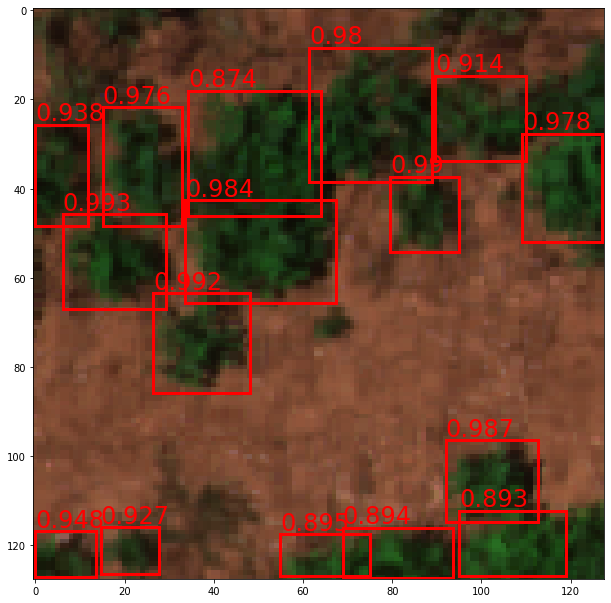

peanut_071219_RGB_dataclip_870.png
20


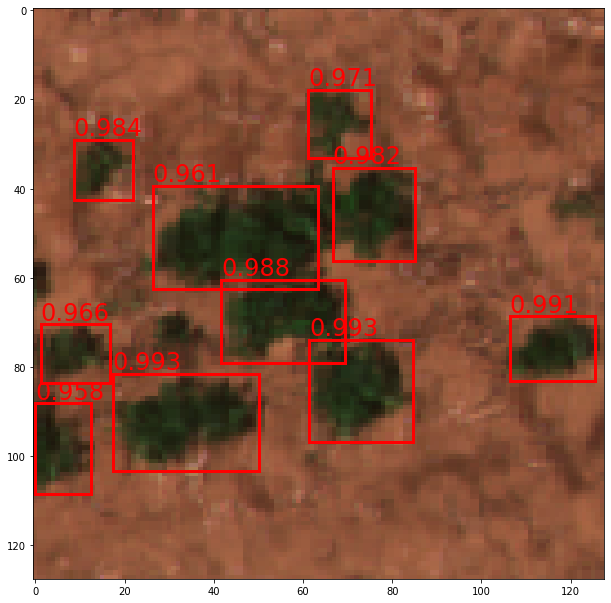

peanut_071219_RGB_dataclip_327.png
41


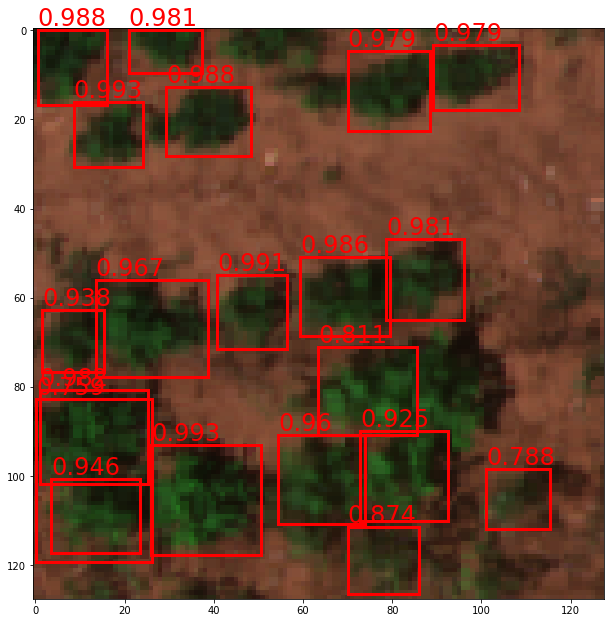

peanut_071219_RGB_dataclip_1162.png
46


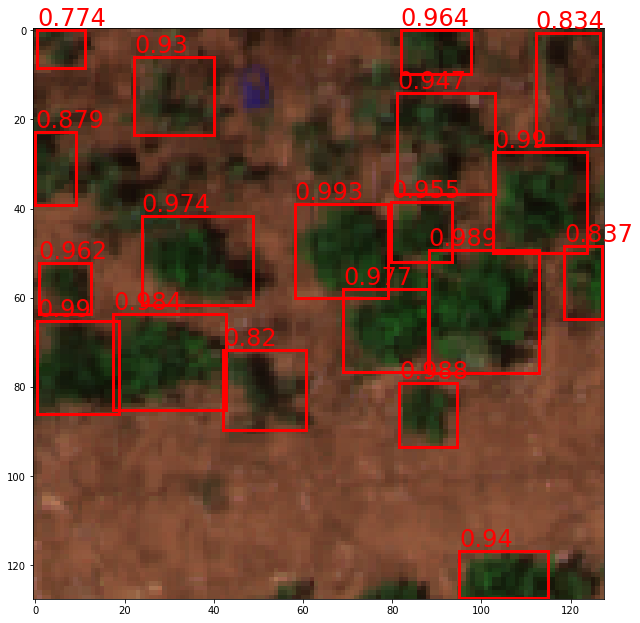

peanut_071219_RGB_dataclip_849.png
13


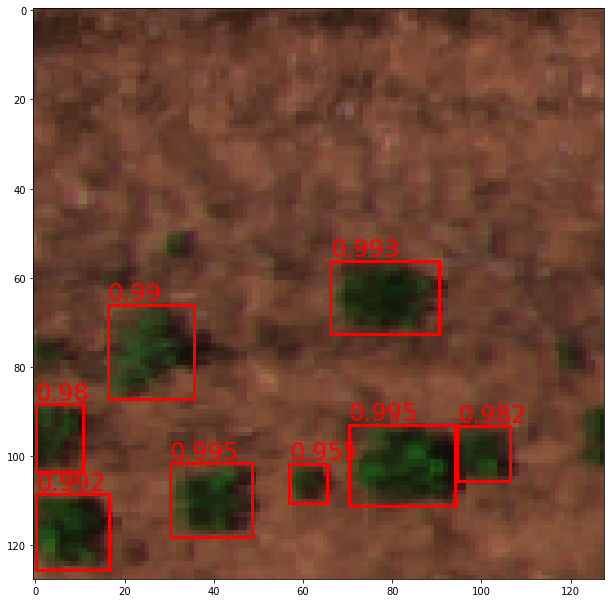

peanut_071219_RGB_dataclip_1415.png
15


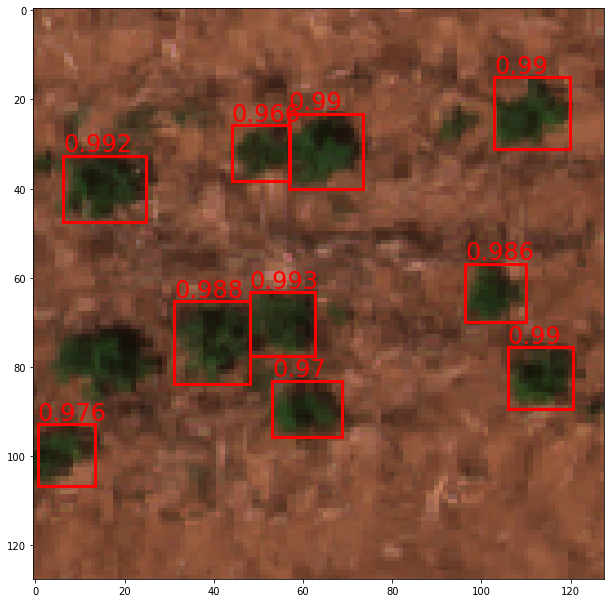

peanut_071219_RGB_dataclip_370.png
37


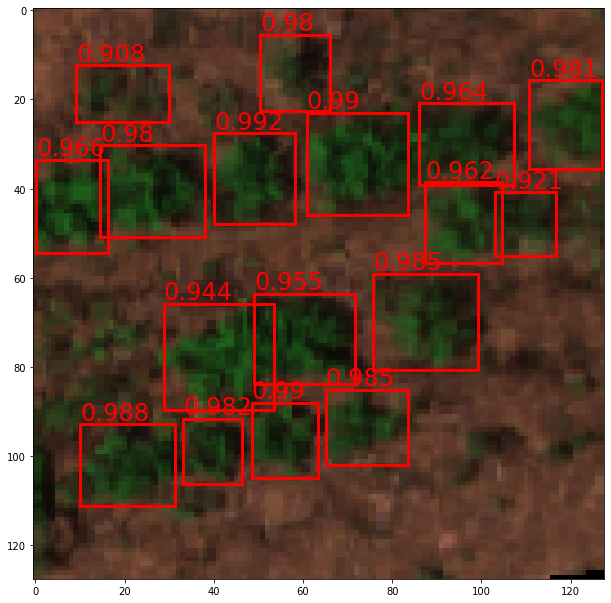

peanut_071219_RGB_dataclip_1068.png
14


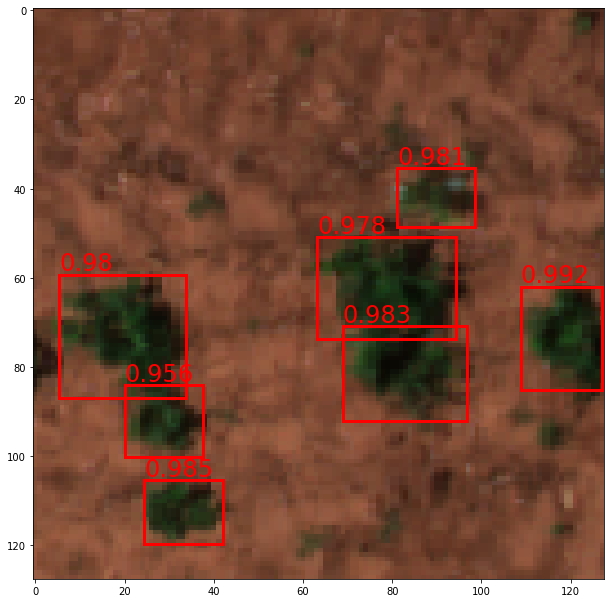

peanut_071219_RGB_dataclip_617.png
35


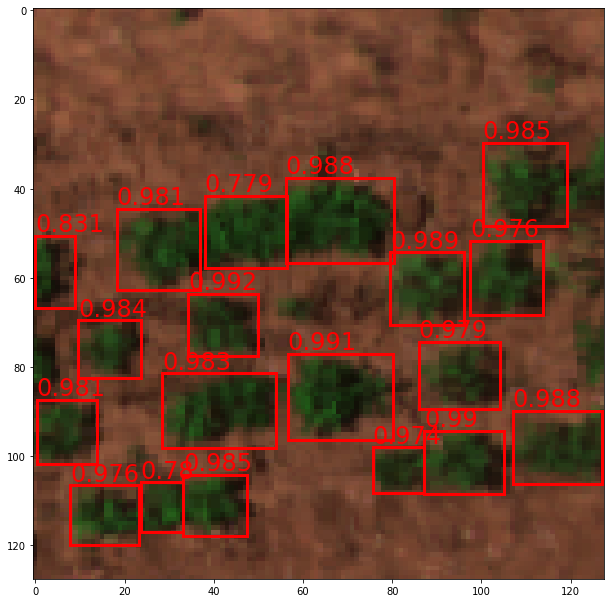

peanut_071219_RGB_dataclip_1065.png
10


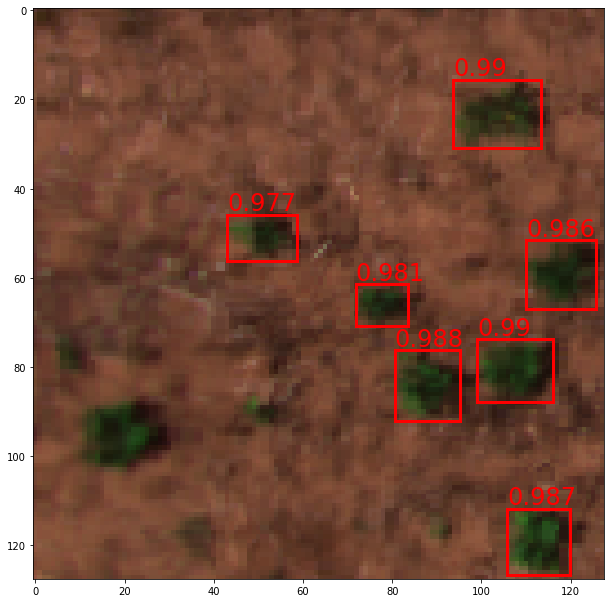

peanut_071219_RGB_dataclip_1436.png
22


In [ ]:
# import random 
from random import sample

preprocess = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.ConvertImageDtype(torch.float)
    ])


model.eval()

testpath = '/content/drive/MyDrive/finalProject/RGB/visual'
testfile_list = os.listdir(testpath)
# for testfile in sample(testfile_list,10):
for testfile in testfile_list:   
    testimg =  Image.open(os.path.join(testpath,testfile)).convert("RGB")

    #
    # Pass the image for preprocessing and the image preprocessed
    #
    img_preprocessed = preprocess(testimg)
    #
    # Reshape, crop, and normalize the input tensor for feeding into network for evaluation
    #
    batch_img_tensor = torch.unsqueeze(img_preprocessed, 0)
    batch_img_cat_tensor = batch_img_tensor.cuda()

    output = model(batch_img_cat_tensor)


    score_threshold = 0.75
    for outputi in output:

        show_box(testimg,outputi, score_threshold)
        print(testfile)
